# PPO ETF Portfolio Allocation - Demo

This notebook demonstrates the trained PPO agent for portfolio allocation across 5 ETFs.

**Note**: The model is pre-trained. This demo loads the model and runs a quick backtest.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from features.feature_engineering import compute_all_features
from backtest.evaluate_metrics import baseline_equal_weight, baseline_monthly_rebalance, compare_strategies
from backtest.backtest_agent import backtest_ppo


## 1. Load Data and Compute Features

In [25]:
data_dir = 'data'
etf_data = pd.read_csv(f"{data_dir}/etf_prices.csv", index_col=0, parse_dates=True)
vix_data = pd.read_csv(f"{data_dir}/vix.csv", index_col=0, parse_dates=True).iloc[:, 0]
try:
    yield_curve_data = pd.read_csv(f"{data_dir}/yield_curve.csv", index_col=0, parse_dates=True)
except Exception as e:
    print(f"Warning: Could not load yield curve data: {e}")
    yield_curve_data = None

print(f"ETF data shape: {etf_data.shape}")
print(f"Date range: {etf_data.index[0]} to {etf_data.index[-1]}")
print(f"ETFs: {list(etf_data.columns)}")

ETF data shape: (3522, 5)
Date range: 2010-01-04 00:00:00 to 2023-12-29 00:00:00
ETFs: ['GLD', 'QQQ', 'SHV', 'SPY', 'TLT']


In [26]:
# Compute features
features_df = compute_all_features(etf_data, vix_data, yield_curve_data)
print(f"Features computed. Shape: {features_df.shape}")
print(f"Feature columns: {len(features_df.columns)}")

Features computed. Shape: (3223, 28)
Feature columns: 28


## 2. Load Pre-trained PPO Model and Backtest

In [27]:
# Backtest on test period (2019-2022)
etf_tickers = ["SPY", "QQQ", "TLT", "GLD", "SHV"]
model_path = "models/ppo_portfolio"

print("Loading pre-trained PPO model...")
ppo_results = backtest_ppo(
    model_path=model_path,
    features_df=features_df,
    etf_tickers=etf_tickers,
    start_date="2019-01-01",
    end_date="2022-12-31",
    initial_balance=100000.0
)

print(f"\n✓ PPO Backtest Complete")
print(f"Final Portfolio Value: ${ppo_results['final_value']:,.2f}")
print(f"Total Return: {ppo_results['total_return']:.2f}%")

Loading pre-trained PPO model...
Loading model from models/ppo_portfolio...
Backtesting on 992 days
Period: 2019-01-02 00:00:00 to 2022-12-30 00:00:00
Step 100/3223, Portfolio Value: $108772.25
Step 200/3223, Portfolio Value: $120295.69
Step 300/3223, Portfolio Value: $118561.99
Step 400/3223, Portfolio Value: $157062.03
Step 500/3223, Portfolio Value: $159090.49
Step 600/3223, Portfolio Value: $163227.89
Step 700/3223, Portfolio Value: $172386.51
Step 800/3223, Portfolio Value: $169205.96
Step 900/3223, Portfolio Value: $158414.50

✓ PPO Backtest Complete
Final Portfolio Value: $144,400.40
Total Return: 44.40%


## 3. Run Baseline Strategies for Comparison

In [20]:
# Filter ETF data for test period
test_etf_data = etf_data[
    (etf_data.index >= pd.Timestamp("2019-01-01")) &
    (etf_data.index <= pd.Timestamp("2022-12-31"))
]

# Equal-weight buy-and-hold
equal_weight_results = baseline_equal_weight(
    test_etf_data,
    start_date="2019-01-01",
    end_date="2022-12-31"
)

# Monthly rebalanced
monthly_rebalance_results = baseline_monthly_rebalance(
    test_etf_data,
    start_date="2019-01-01",
    end_date="2022-12-31"
)

print("✓ Baseline strategies computed")

✓ Baseline strategies computed


## 4. Compare Strategies

In [13]:
# Create comparison
results_dict = {
    "PPO Agent": ppo_results,
    "Buy and Hold": equal_weight_results,
    "Monthly Rebalance": monthly_rebalance_results
}

comparison_df = compare_strategies(results_dict)
print("\n" + "="*70)
print("STRATEGY PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


STRATEGY PERFORMANCE COMPARISON
         Strategy  Total Return (%)  Annualized Return (%)  Volatility (%)  Sharpe Ratio  Max Drawdown (%)  Calmar Ratio  Win Rate (%)
        PPO Agent         44.400401               9.793448       13.515723      0.724597        -24.351166      0.402176     55.903128
     Buy and Hold         36.206442               8.039541       10.776077      0.746055        -20.533883      0.391526     55.809335
Monthly Rebalance         33.800037               7.558677       10.609600      0.712438        -20.951142      0.360776     55.710030


## 5. Visualize Portfolio Performance

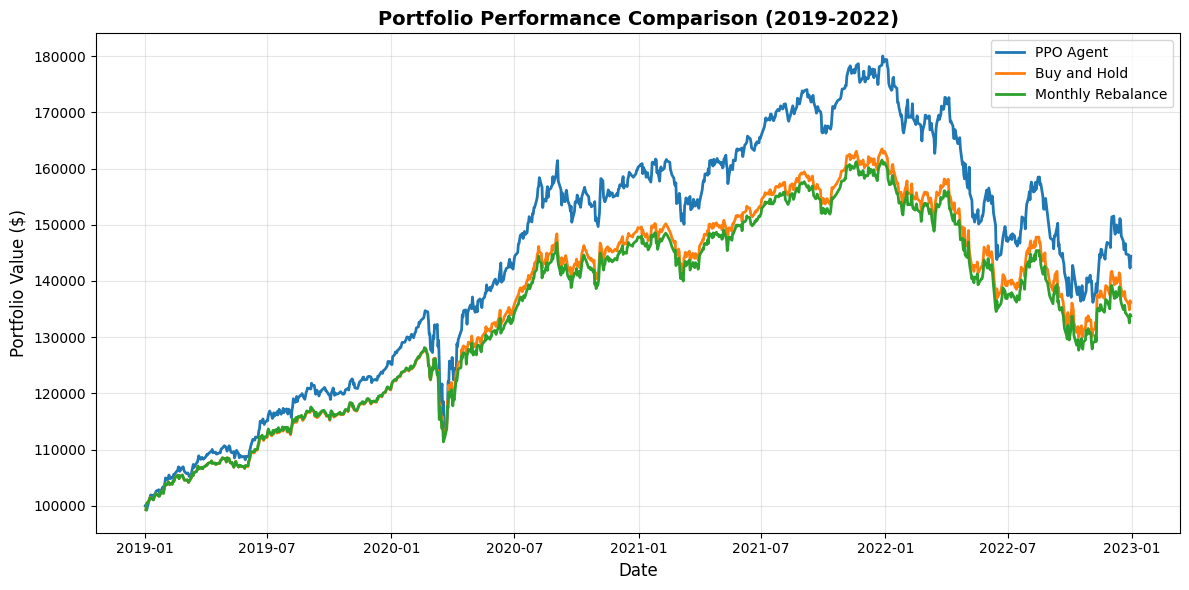

In [ ]:
plt.clf()
plt.close('all')
plt.figure(figsize=(12, 6))

for name, res in results_dict.items():
    dates = res["dates"]
    values = res["portfolio_values"]
    if len(values) == len(dates) + 1:
        values = values[1:]
    plt.plot(dates, values, label=name, linewidth=2)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value ($)", fontsize=12)
plt.title("Portfolio Performance Comparison (2019-2022)", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# Note: plt.show() not needed with %matplotlib inline



## 6. Key Insights

In [23]:
print("\n" + "="*70)
print("KEY METRICS SUMMARY")
print("="*70)

for strategy_name, results in results_dict.items():
    print(f"\n{strategy_name}:")
    print(f"  Total Return: {results['total_return']:.2f}%")
    print(f"  Sharpe Ratio: {results['sharpe_ratio']:.3f}")
    print(f"  Max Drawdown: {results['max_drawdown']:.2f}%")
    print(f"  Volatility: {results['volatility']:.2f}%")

if 'turnover' in ppo_results:
    print(f"\nPPO Agent Turnover: {ppo_results['turnover']:.4f}")

print("\n" + "="*70)


KEY METRICS SUMMARY

PPO Agent:
  Total Return: 44.40%
  Sharpe Ratio: 0.725
  Max Drawdown: -24.35%
  Volatility: 13.52%

Buy and Hold:
  Total Return: 36.21%
  Sharpe Ratio: 0.746
  Max Drawdown: -20.53%
  Volatility: 10.78%

Monthly Rebalance:
  Total Return: 33.80%
  Sharpe Ratio: 0.712
  Max Drawdown: -20.95%
  Volatility: 10.61%

PPO Agent Turnover: 0.0000



## Summary

This demo demonstrates:
1. **Loading pre-trained PPO model** - The agent learned portfolio allocation from 2010-2018 data
2. **Backtesting on 2019-2022** - Tests performance on unseen market conditions including COVID-19
3. **Baseline comparison** - Compares against simple strategies (buy-and-hold, monthly rebalance)
4. **Performance metrics** - Evaluates using Sharpe ratio, drawdown, volatility, and returns

The PPO agent learns to dynamically adjust portfolio weights based on market features (momentum, volatility, VIX, yield curve) rather than maintaining static allocations.